In [2]:
## BEGIN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import pickle as cp
import scipy.optimize as opt
from scipy.optimize import curve_fit as fit
#import mps
import cProfile
import subprocess
from scipy.special import hyp2f1, erf
from scipy.optimize import brentq

import itertools

# Ising loop model on square lattice

For the curious, I am using a cluster algorithm based on the Fortuin-Kasterleyn (FK) representation. 
It is a slightly different high-$T$ expansion of the Ising model. One starts by rewriting the Boltzmann weight on a bond as follows
$$ e^{K \sigma \sigma'} \propto (1 + x \delta_{\sigma, \sigma'}) \,,\, x = e^{2K}-1 $$
Doing this for all bonds, we obtain an expansion of the partition function as a sum of "FK cluster" configurations. The relative weight of a FK cluster configuration is 
$$ w^{\text{number of active bonds}} (1-w)^{\text{number of inactive bonds}} Q^{\text{number of clusters}} $$
where 
$$ w = \frac{x}{1+x} = 1-e^{-2K} $$
and $$Q = 2 \; \text{(Ising)}$$
(For general $Q$, we get the $Q$-state Potts model). The active bonds are the ones we chose the term $\delta_{\sigma, \sigma'}$; a cluster is a connected component of the graph formed by the active bonds. 

The FK representation defines a joint distribution of cluster and spin configurations, $(C, \sigma)$. We have the conditional probability 
$$
P(\sigma | C) = Q^{-\text{number of clusters}} \,,\, 
$$
if the $\sigma$ is such that the sites of each FK cluster have the same spin. Otherwise $P(\sigma|C) = 0$. So it is easy to sample $\sigma$ given $C$: we choose a spin value for each FK cluster randomly and independently. 

Moreover it is also easy to sample $C$ given $\sigma$. By Bayes rule
$$
P(C | \sigma) \propto w^{\text{number of active bonds}} (1-w)^{\text{number of inactive bonds}} \,,\, 
$$
if the sites of each FK cluster have the same spin. Therefore, to sample $C$ given $\sigma$, 
- all the bonds with disaligned spin must be inactive;
- for each bond with aligned spin, it is acitve with probability $w$. 

In [16]:
#constructing the graph
lb=7
L = 2 ** lb
xy2i = lambda x,y:x*L + y
xs, ys =  np.arange(L**2) // L, np.arange(L**2) % L
xp, xm = (xs + 1) % L, (xs - 1) % L
yp, ym = (ys + 1) % L, (ys - 1) % L


matrix = sp.coo_matrix((L**2, L**2), dtype= int)
inds = np.array([ xy2i(xp, ys), xy2i(xm, ys), 
                 xy2i(xs , yp), xy2i(xs, ym)]).T.reshape(-1)
data = np.ones_like(inds, dtype=int)
indptr = np.arange(L ** 2 + 1) * 4
full_graph = sp.csc_matrix((data, inds, indptr),shape=(L**2, L**2))

## cut all the boundaries
if 0:
    lil = full_graph.tolil()
    lil[:L, -L:] = 0
    lil[-L:, :L] = 0
    lil[::L, L-1::L] = 0
    lil[L-1::L, ::L] = 0
    full_graph = lil.tocsc()
##############

edges = sp.coo_matrix(full_graph)
ut_ind = edges.row > edges.col
edges = sp.coo_matrix((edges.data[ut_ind], (edges.row[ut_ind], edges.col[ut_ind])), shape = (L**2,L**2))
degree = np.diff(full_graph.indptr)
Nv = L ** 2
Ne = len(edges.row)
print(Nv, Ne)
ind_boundary = np.where((xs == 0) + (xs == L-1) + (ys == 0) + (ys == L-1))[0]

16384 32768


In [17]:
spin = np.zeros(Nv, dtype=int)
w = 2 - 2 ** .5 # critical point

In [18]:
# where to save 2p functin and the distances to sample
rs = 2 ** np.arange(lb)
ans = np.zeros(len(rs) + 1)

In [21]:
#get spin clusters
for j in range(100):
    # start from 4-state
    same = (spin[edges.row] == spin[edges.col])  
    #red = (spin[edges.row] + spin[edges.col] == 3)
    edges.data[:] = 0
    edges.data[same] = (rnd.rand(np.sum(same)) < w) # same color: throw a dice
    #edges.data[red] = 1 # 
    FK_graph = edges.tocsc()
    FK_graph.eliminate_zeros()
    n_cl, FK_clusters = sp.csgraph.connected_components(FK_graph, directed=0, return_labels=1)
    
    FK_spin = rnd.randint(2, size = n_cl) * 2 - 1
    #FK_spin[np.unique(FK_clusters[ind_boundary])] *= 0
    spin[:] = FK_spin[FK_clusters]
    print(n_cl, end = " ")

    # calculate 2p function
    for j,x in enumerate(rs):
        intersect = (spin.reshape(L,L) * np.roll(spin.reshape(L,L), x, axis = 1))
        ans[j+1] += (np.sum(intersect) / L ** 2)
    ans[0] += 1

2124 2115 2212 2028 2027 2103 1955 1953 1951 1954 2057 2075 2037 1988 1973 2035 2114 2058 2074 2068 2128 2197 2199 2221 2202 2244 2254 2188 2019 2086 2130 2154 2190 2111 2058 2132 2206 2258 2240 2201 2124 2166 2079 2105 2084 2092 2050 2076 2090 2063 2082 2018 2018 2110 2031 1976 2055 1962 2010 2038 2025 2117 2087 2103 2103 2233 2184 2148 2124 2130 2124 2082 2118 2142 2183 2120 2203 2189 2223 2144 2164 2193 2267 2205 2093 2047 1984 2001 2065 2149 2012 2022 2037 1983 1894 2016 2044 2032 2081 2078 

Text(0, 0.5, '$\\left< S_0 S_r \\right>$')

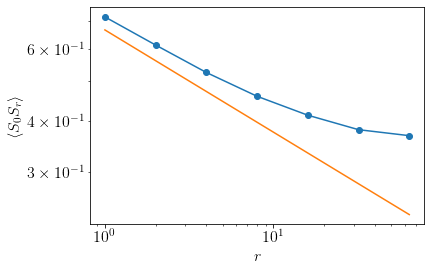

In [22]:
plt.loglog(rs, ans[1:] / ans[0], "o-")
plt.plot(rs, rs ** (-1/4) / 1.5)
plt.xlabel("$r$")
plt.ylabel(r"$\left< S_0 S_r \right>$")

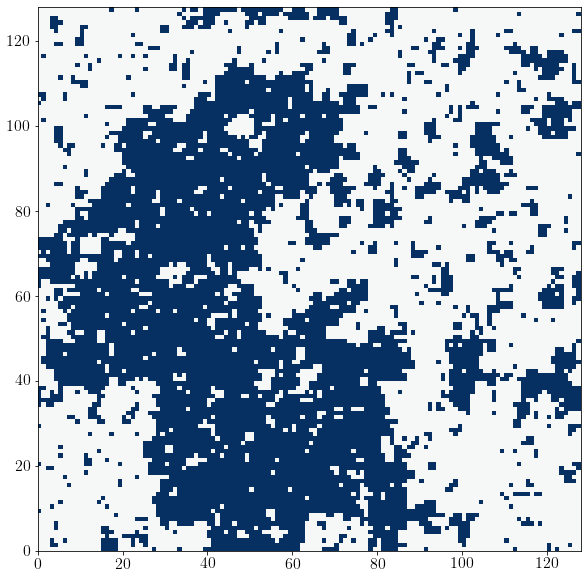

In [23]:
plt.figure(1, figsize = (10,10))
plt.pcolor(spin.reshape(-1, L).T, cmap = "RdBu", vmin = -3, vmax = 1)
if 0:
    for k, (i,j) in enumerate(zip(edges.row, edges.col)):
        #diff = spin[1] 
        #d = edges.data[k]
        if spin[i] == spin[j]: continue

        z1, z2 = xs[i] +.5 + 1.j*(ys[i]+.5), (xs[j]+.5) + 1.j * (ys[j] + .5)
        #if abs(z1 - z2) > 2: continue
        zm = (z1 +z2)/2
        w1 = (z1 - zm) * 1.j + zm
        w2 = 2 * zm - w1
        plt.plot([w1.real, w2.real], [w1.imag, w2.imag], c = "red")
plt.gca().set_aspect('equal')


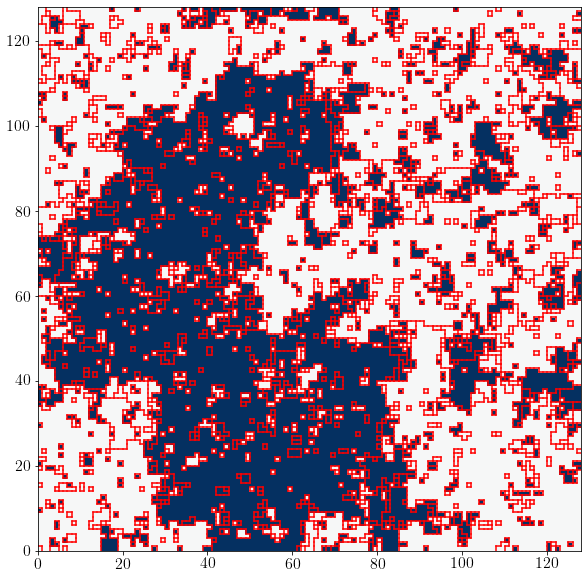

In [26]:
# FK clusters
# do this for small systems!!
plt.figure(1, figsize = (10,10))
plt.pcolor(spin.reshape(-1, L).T, cmap = "RdBu", vmin = -3, vmax = 1)

for k, (i,j) in enumerate(zip(edges.row, edges.col)):
    #diff = spin[1] 
    #d = edges.data[k]
    if FK_clusters[i] == FK_clusters[j]: continue
    
    z1, z2 = xs[i] +.5 + 1.j*(ys[i]+.5), (xs[j]+.5) + 1.j * (ys[j] + .5)
    if abs(z1 - z2) > 2: continue
    zm = (z1 +z2)/2
    w1 = (z1 - zm) * 1.j + zm
    w2 = 2 * zm - w1
    plt.plot([w1.real, w2.real], [w1.imag, w2.imag], c = "red")
plt.gca().set_aspect('equal')
